In [56]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# After running this cell, you will be prompted to authorize access to your Google Drive.
# Follow the link, copy the authorization code, and paste it in the input field.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [85]:
import librosa
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn.metrics
import os
from glob import glob
import sklearn
import numpy as np

In [86]:
import numpy as np

def _framing(x, win_len, overlap):
    """
    Divides input signal into overlapping frames of equal length
    Parameters
    ----------
    x : input signal
    win_len : frame length
    overlap : overlapping length
    Returns
    -------
    a list of frames
    """
    n_frames = int(np.round((len(x) - overlap) / (win_len - overlap)))
    x_frames = np.zeros((n_frames, win_len))
    for i in range(n_frames):
        start = i * (win_len - overlap)
        end = start + win_len
        x_frames[i] = x[start:end] if len(x[start:end]) == win_len else np.append(x[start:end], np.zeros(win_len % len(x[start:end])))
    return x_frames

def _deframing(x, x_vad, win_len, overlap):
    """
    Combines overlapping frames
    Parameters
    ----------
    x : original input signal
    x_vad : list of voice-activated frames
    win_len : frame length
    overlap : overlapping length
    Returns
    -------
    a signal of length equal to the original input signal
    """
    x_voice = np.zeros((len(x)))
    for i in range(len(x_vad)):
        start = i * (win_len - overlap)
        end = i * (win_len - overlap) + win_len
        x_voice[start:end] = x_vad[i]
    for i in range(len(x_voice)):
        if x_voice[i]:
            x_voice[i] = x[i]
    return np.trim_zeros(x_voice)

def _calculate_nrg(x_frames):
    """
    Calculates frame energy
    Parameters
    ----------
    x_frames : list of frames
    Returns
    -------
    a list of normalized energies of respective frames
    """
    nrgs = np.diagonal(np.dot(x_frames, x_frames.T))
    log_nrgs = np.log(nrgs)
    norm_nrgs = (2 * (log_nrgs - min(log_nrgs)) / (max(log_nrgs) - min(log_nrgs))) - 1
    return norm_nrgs

def VAD(x, fs, db, nrg_th=0, context=5):
    """
    Performs voice activity detection by comparing frame energy to a threshold
    Parameters
    ----------
    x : original input signal
    fs : sampling rate
    db : Database ID (RAVDESS:1 and SAVEE:2)
    nrg_th: energy threshold
    context: number of neighboring frames to be used in comparison
    Returns
    -------
    a list of voice-activated frames; where 1 indicates the presence of voice and 0 indicates the absence of voice
    """
    percent_th = 0.4 if db == 1 else 0.3
    win_len = int(fs * 0.025)
    overlap = int(win_len * 0.25)
    x_frames = _framing(x, win_len, overlap)
    n_frames = int(x_frames.shape[0])
    x_nrgs = _calculate_nrg(x_frames)
    x_vad = np.zeros((n_frames, 1))
    for i in range(n_frames):
        start = max(0, i - context)
        end = min(n_frames, i + context)
        num_nrgs_above_th = np.sum(x_nrgs[start:end, ...] > nrg_th)
        total_num_nrgs = end - start + 1
        x_vad[i] = (num_nrgs_above_th / total_num_nrgs) > percent_th
    return _deframing(x, x_vad, win_len, overlap)


In [87]:
# Example usage
fs = 44100  # Replace with your actual sampling rate
db = 1  # Replace with your database ID
nrg_th = 0.5  # Replace with your energy threshold
context = 5  # Replace with your context size

# Replace 'your_audio_signal' with your actual audio signal
your_audio_signal = np.random.randn(10000)

resulting_signal = VAD(your_audio_signal, fs, db, nrg_th, context)
resulting_signal

array([], dtype=float64)

In [88]:
import os
from glob import glob

database_path = '/content/drive/MyDrive/Database/'

audio_paths = glob('{}/**/*.wav'.format(database_path), recursive=True)
audio_paths = [x.replace(os.sep, '/') for x in audio_paths]
# Extracting subdirectory names as labels
labels = [os.path.basename(os.path.dirname(x)) for x in audio_paths]

# Optionally, you can encode the labels to numerical values
label_encode = {label: i for i, label in enumerate(set(labels))}
encoded_labels = [label_encode[label] for label in labels]

# Print or use the labels and encoded_labels as needed
print(labels)
print(encoded_labels)


['surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised'

In [89]:
import numpy as np
import librosa
from sklearn.preprocessing import StandardScaler, LabelEncoder
from keras.utils import to_categorical


sample_rate = 16000
FRAME_LENGTH = int(0.025 * sample_rate)
HOP_LENGTH = int(0.25 * FRAME_LENGTH)

n_classes = len(set(labels))
n_mfccs = 19
n_audio = len(audio_paths)
X = np.empty((n_audio, n_mfccs + 4), dtype=np.float32)
Y = np.empty((n_audio, n_classes), dtype=np.uint8)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels)
Y = to_categorical(y_encoded, num_classes=n_classes)

for i, (path, label) in enumerate(zip(audio_paths, y_encoded)):
    audio, _ = librosa.load(path, sr=sample_rate, res_type='fft', offset=0.5)
    waveform = VAD(audio, sample_rate, int(db))
    waveform_pad = np.zeros((int(sample_rate * 5,)))
    waveform_pad[:len(waveform)] = waveform
    mfccs = np.mean(librosa.feature.mfcc(y=waveform_pad, sr=sample_rate, n_mfcc=n_mfccs, n_fft=1024, win_length=FRAME_LENGTH, hop_length=HOP_LENGTH, window='hamming', n_mels=128, fmax=sample_rate/2).T, axis=0)
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=waveform_pad, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH))
    rmse = np.mean(librosa.feature.rms(y=waveform_pad, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH))
    pitch, magnitude = librosa.piptrack(y=waveform, sr=sample_rate, n_fft=1024, hop_length=HOP_LENGTH, win_length=FRAME_LENGTH, window='hamming')
    pitch = np.mean(pitch[np.where(magnitude > 0)])
    centroid = np.mean(librosa.feature.spectral_centroid(y=waveform, sr=sample_rate, n_fft=1024, hop_length=HOP_LENGTH, win_length=FRAME_LENGTH, window='hamming'))
    X[i, ...] = np.append(mfccs, (rmse, centroid, zcr, pitch))
    Y[i, ...] = to_categorical(label, num_classes=n_classes)

scaler = StandardScaler()
X = scaler.fit_transform(X)
X = X[..., np.newaxis]


In [121]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.05, random_state=42)
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.025, random_state=42)

In [122]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=32, kernel_size=9, strides=1, padding='same', input_shape=(n_mfccs + 4, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('elu'),
        tf.keras.layers.MaxPool1D(pool_size=2, strides=2),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Conv1D(filters=64, kernel_size=7, strides=1, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('elu'),
        tf.keras.layers.MaxPool1D(pool_size=2, strides=2),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Conv1D(filters=128, kernel_size=5, strides=1, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('elu'),
        tf.keras.layers.MaxPool1D(pool_size=2, strides=2),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.LSTM(32, return_sequences=True),

        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(units=n_classes, activation='softmax')
        ])

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_36 (Conv1D)          (None, 23, 32)            320       
                                                                 
 batch_normalization_36 (Ba  (None, 23, 32)            128       
 tchNormalization)                                               
                                                                 
 activation_36 (Activation)  (None, 23, 32)            0         
                                                                 
 max_pooling1d_36 (MaxPooli  (None, 11, 32)            0         
 ng1D)                                                           
                                                                 
 dropout_36 (Dropout)        (None, 11, 32)            0         
                                                                 
 conv1d_37 (Conv1D)          (None, 11, 64)          

In [123]:
import tensorflow as tf

opt = tf.keras.optimizers.legacy.SGD(learning_rate=0.01, decay=1e-3, momentum=0.8)


In [124]:
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history = model.fit(X_train, Y_train, batch_size=64, epochs=1100, validation_data=(X_val, Y_val))
import matplotlib.pyplot as plt

Epoch 1/1100
22/22 [==============================] - 6s 78ms/step - loss: 2.0832 - categorical_accuracy: 0.1331 - val_loss: 2.0509 - val_categorical_accuracy: 0.2329
Epoch 2/1100
22/22 [==============================] - 1s 24ms/step - loss: 2.0085 - categorical_accuracy: 0.2256 - val_loss: 2.0179 - val_categorical_accuracy: 0.3562
Epoch 3/1100
22/22 [==============================] - 0s 18ms/step - loss: 1.9677 - categorical_accuracy: 0.2286 - val_loss: 1.9853 - val_categorical_accuracy: 0.3151
Epoch 4/1100
22/22 [==============================] - 0s 16ms/step - loss: 1.9362 - categorical_accuracy: 0.2678 - val_loss: 1.9444 - val_categorical_accuracy: 0.3699
Epoch 5/1100
22/22 [==============================] - 0s 16ms/step - loss: 1.8927 - categorical_accuracy: 0.3047 - val_loss: 1.9114 - val_categorical_accuracy: 0.3836
Epoch 6/1100
22/22 [==============================] - 0s 16ms/step - loss: 1.8648 - categorical_accuracy: 0.3151 - val_loss: 1.8725 - val_categorical_accuracy: 0.411

<ipython-input-126-d10d0569b26a>:2: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


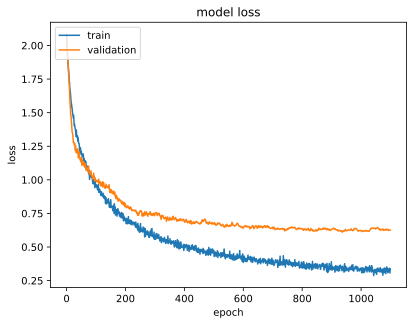

In [126]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

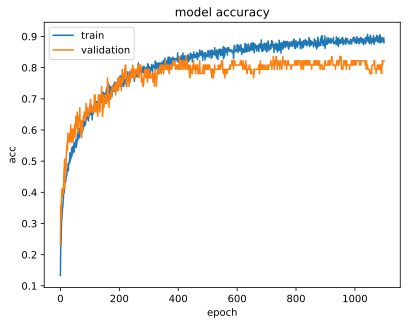

In [127]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [125]:
loss, acc = model.evaluate(X_test, Y_test)
print("Model Accuracy: {:5.2f}%".format(100*acc))

2/2 [==============================] - 0s 8ms/step - loss: 0.5032 - categorical_accuracy: 0.8571
Model Accuracy: 85.71%


In [128]:
# Remplacez 'chemin_vers_votre_audio.wav' par le chemin réel vers votre fichier audio WAV
audio_path_test = '/content/W.wav'

# Charger l'audio
audio_test, _ = librosa.load(audio_path_test, sr=sample_rate, res_type='fft', offset=0.5)

# Appliquer le VAD
waveform_test = VAD(audio_test, sample_rate, int(db))
waveform_pad_test = np.zeros((int(sample_rate * 5,)))
waveform_pad_test[:len(waveform_test)] = waveform_test

# Calculer les caractéristiques
mfccs_test = np.mean(librosa.feature.mfcc(y=waveform_pad_test, sr=sample_rate, n_mfcc=n_mfccs, n_fft=1024, win_length=FRAME_LENGTH, hop_length=HOP_LENGTH, window='hamming', n_mels=128, fmax=sample_rate/2).T, axis=0)
zcr_test = np.mean(librosa.feature.zero_crossing_rate(y=waveform_pad_test, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH))
rmse_test = np.mean(librosa.feature.rms(y=waveform_pad_test, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH))
pitch_test, magnitude_test = librosa.piptrack(y=waveform_test, sr=sample_rate, n_fft=1024, hop_length=HOP_LENGTH, win_length=FRAME_LENGTH, window='hamming')
pitch_test = np.mean(pitch_test[np.where(magnitude_test > 0)])
centroid_test = np.mean(librosa.feature.spectral_centroid(y=waveform_test, sr=sample_rate, n_fft=1024, hop_length=HOP_LENGTH, win_length=FRAME_LENGTH, window='hamming'))
audio_features_test = np.append(mfccs_test, (rmse_test, centroid_test, zcr_test, pitch_test))

# Normaliser les caractéristiques
audio_features_test = scaler.transform(audio_features_test.reshape(1, -1))
audio_features_test = audio_features_test[..., np.newaxis]

# Effectuer la prédiction
predictions = model.predict(audio_features_test)

# Afficher les résultats
print("Probabilités pour chaque classe :", predictions)
predicted_class = np.argmax(predictions)
predicted_label = label_encoder.classes_[predicted_class]
print("Classe prédite :", predicted_label)


1/1 [==============================] - 0s 499ms/step
Probabilités pour chaque classe : [[7.5074697e-01 3.0883902e-03 2.4527468e-01 2.0611694e-04 3.7748126e-05
  8.4806170e-06 6.3734601e-04 2.3281486e-07]]
Classe prédite : anger


In [129]:
# Remplacez 'chemin_vers_votre_audio.wav' par le chemin réel vers votre fichier audio WAV
audio_path_test = '/content/videos_cnn-audio_data_cat_004ae714_nohash_0.wav'

# Charger l'audio
audio_test, _ = librosa.load(audio_path_test, sr=sample_rate, res_type='fft', offset=0.5)

# Appliquer le VAD
waveform_test = VAD(audio_test, sample_rate, int(db))
waveform_pad_test = np.zeros((int(sample_rate * 5,)))
waveform_pad_test[:len(waveform_test)] = waveform_test

# Calculer les caractéristiques
mfccs_test = np.mean(librosa.feature.mfcc(y=waveform_pad_test, sr=sample_rate, n_mfcc=n_mfccs, n_fft=1024, win_length=FRAME_LENGTH, hop_length=HOP_LENGTH, window='hamming', n_mels=128, fmax=sample_rate/2).T, axis=0)
zcr_test = np.mean(librosa.feature.zero_crossing_rate(y=waveform_pad_test, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH))
rmse_test = np.mean(librosa.feature.rms(y=waveform_pad_test, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH))
pitch_test, magnitude_test = librosa.piptrack(y=waveform_test, sr=sample_rate, n_fft=1024, hop_length=HOP_LENGTH, win_length=FRAME_LENGTH, window='hamming')
pitch_test = np.mean(pitch_test[np.where(magnitude_test > 0)])
centroid_test = np.mean(librosa.feature.spectral_centroid(y=waveform_test, sr=sample_rate, n_fft=1024, hop_length=HOP_LENGTH, win_length=FRAME_LENGTH, window='hamming'))
audio_features_test = np.append(mfccs_test, (rmse_test, centroid_test, zcr_test, pitch_test))

# Normaliser les caractéristiques
audio_features_test = scaler.transform(audio_features_test.reshape(1, -1))
audio_features_test = audio_features_test[..., np.newaxis]

# Effectuer la prédiction
predictions = model.predict(audio_features_test)

# Afficher les résultats
print("Probabilités pour chaque classe :", predictions)
predicted_class = np.argmax(predictions)
predicted_label = label_encoder.classes_[predicted_class]
print("Classe prédite :", predicted_label)


1/1 [==============================] - 0s 40ms/step
Probabilités pour chaque classe : [[1.3619615e-04 2.0197664e-05 1.0686836e-04 9.7799975e-01 1.4401572e-04
  5.9994218e-05 1.8113419e-04 2.1351853e-02]]
Classe prédite : fear


In [130]:
# Remplacez 'chemin_vers_votre_audio.wav' par le chemin réel vers votre fichier audio WAV
audio_path_test = '/content/sadness_audio.wav'

# Charger l'audio
audio_test, _ = librosa.load(audio_path_test, sr=sample_rate, res_type='fft', offset=0.5)

# Appliquer le VAD
waveform_test = VAD(audio_test, sample_rate, int(db))
waveform_pad_test = np.zeros((int(sample_rate * 5,)))
waveform_pad_test[:len(waveform_test)] = waveform_test

# Calculer les caractéristiques
mfccs_test = np.mean(librosa.feature.mfcc(y=waveform_pad_test, sr=sample_rate, n_mfcc=n_mfccs, n_fft=1024, win_length=FRAME_LENGTH, hop_length=HOP_LENGTH, window='hamming', n_mels=128, fmax=sample_rate/2).T, axis=0)
zcr_test = np.mean(librosa.feature.zero_crossing_rate(y=waveform_pad_test, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH))
rmse_test = np.mean(librosa.feature.rms(y=waveform_pad_test, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH))
pitch_test, magnitude_test = librosa.piptrack(y=waveform_test, sr=sample_rate, n_fft=1024, hop_length=HOP_LENGTH, win_length=FRAME_LENGTH, window='hamming')
pitch_test = np.mean(pitch_test[np.where(magnitude_test > 0)])
centroid_test = np.mean(librosa.feature.spectral_centroid(y=waveform_test, sr=sample_rate, n_fft=1024, hop_length=HOP_LENGTH, win_length=FRAME_LENGTH, window='hamming'))
audio_features_test = np.append(mfccs_test, (rmse_test, centroid_test, zcr_test, pitch_test))

# Normaliser les caractéristiques
audio_features_test = scaler.transform(audio_features_test.reshape(1, -1))
audio_features_test = audio_features_test[..., np.newaxis]

# Effectuer la prédiction
predictions = model.predict(audio_features_test)

# Afficher les résultats
print("Probabilités pour chaque classe :", predictions)
predicted_class = np.argmax(predictions)
predicted_label = label_encoder.classes_[predicted_class]
print("Classe prédite :", predicted_label)


1/1 [==============================] - 0s 24ms/step
Probabilités pour chaque classe : [[7.6512997e-06 2.1828872e-03 3.9141618e-05 1.3968818e-02 4.4191707e-04
  3.5773015e-03 9.7965688e-01 1.2534960e-04]]
Classe prédite : sadness


In [132]:
# Remplacez 'chemin_vers_votre_audio.wav' par le chemin réel vers votre fichier audio WAV
audio_path_test = '/content/surprised_audio.wav'

# Charger l'audio
audio_test, _ = librosa.load(audio_path_test, sr=sample_rate, res_type='fft', offset=0.5)

# Appliquer le VAD
waveform_test = VAD(audio_test, sample_rate, int(db))
waveform_pad_test = np.zeros((int(sample_rate * 5,)))
waveform_pad_test[:len(waveform_test)] = waveform_test

# Calculer les caractéristiques
mfccs_test = np.mean(librosa.feature.mfcc(y=waveform_pad_test, sr=sample_rate, n_mfcc=n_mfccs, n_fft=1024, win_length=FRAME_LENGTH, hop_length=HOP_LENGTH, window='hamming', n_mels=128, fmax=sample_rate/2).T, axis=0)
zcr_test = np.mean(librosa.feature.zero_crossing_rate(y=waveform_pad_test, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH))
rmse_test = np.mean(librosa.feature.rms(y=waveform_pad_test, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH))
pitch_test, magnitude_test = librosa.piptrack(y=waveform_test, sr=sample_rate, n_fft=1024, hop_length=HOP_LENGTH, win_length=FRAME_LENGTH, window='hamming')
pitch_test = np.mean(pitch_test[np.where(magnitude_test > 0)])
centroid_test = np.mean(librosa.feature.spectral_centroid(y=waveform_test, sr=sample_rate, n_fft=1024, hop_length=HOP_LENGTH, win_length=FRAME_LENGTH, window='hamming'))
audio_features_test = np.append(mfccs_test, (rmse_test, centroid_test, zcr_test, pitch_test))

# Normaliser les caractéristiques
audio_features_test = scaler.transform(audio_features_test.reshape(1, -1))
audio_features_test = audio_features_test[..., np.newaxis]

# Effectuer la prédiction
predictions = model.predict(audio_features_test)

# Afficher les résultats
print("Probabilités pour chaque classe :", predictions)
predicted_class = np.argmax(predictions)
predicted_label = label_encoder.classes_[predicted_class]
print("Classe prédite :", predicted_label)


1/1 [==============================] - 0s 20ms/step
Probabilités pour chaque classe : [[3.0300656e-04 4.2291549e-03 2.6474059e-05 3.9887428e-03 5.5739332e-02
  5.0402127e-02 7.7046995e-04 8.8454062e-01]]
Classe prédite : surprised
